In [376]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [377]:
df=pd.read_csv('full.csv')

In [378]:
df.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,flag,yearsince,Item_Weight,Item_Visibility
0,0,FDA15,249.8092,3735.1380,Dairy,1999,OUT049,1,2.0,2,1,20,9.30,0.016047
1,1,DRC01,48.2692,443.4228,Soft Drinks,2009,OUT018,3,2.0,3,1,10,5.92,0.019278
2,0,FDN15,141.6180,2097.2700,Meat,1999,OUT049,1,2.0,2,1,20,17.50,0.016760
3,1,FDX07,182.0950,732.3800,Fruits and Vegetables,1998,OUT010,3,2.0,1,1,21,19.20,0.109247
4,0,NCD19,53.8614,994.7052,Household,1987,OUT013,3,3.0,2,1,32,8.93,0.057198


In [379]:
train=df[df['flag']==1].drop('flag',1).reset_index(drop=True)
test=df[df['flag']==0].drop('flag',1).reset_index(drop=True)
sub=test[['Item_Identifier','Outlet_Identifier']]

In [380]:
col1=['Item_Identifier','Outlet_Identifier','Item_Type']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in col1:
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i])

In [381]:
item_cost=train.groupby('Item_Identifier').agg({'Item_Outlet_Sales' : ['mean', 'max','min'] }).reset_index()
item_cost.columns = ['_'.join(col).strip() for col in item_cost.columns.values]
train=pd.merge(train,item_cost, left_on='Item_Identifier', right_on='Item_Identifier_',how='left').drop('Item_Identifier_',1)
test=pd.merge(test,item_cost, left_on='Item_Identifier', right_on='Item_Identifier_',how='left').drop('Item_Identifier_',1)

In [382]:
outlet_cost=train.groupby('Outlet_Identifier').agg({'Item_Outlet_Sales' : ['mean', 'max','min'] }).reset_index()
outlet_cost.columns = ['_'.join(col).strip() for col in outlet_cost.columns.values]
train=pd.merge(train,outlet_cost, left_on='Outlet_Identifier', 
               right_on='Outlet_Identifier_',how='left').drop('Outlet_Identifier_',1)
test=pd.merge(test,outlet_cost, left_on='Outlet_Identifier', 
               right_on='Outlet_Identifier_',how='left').drop('Outlet_Identifier_',1)

In [383]:
Outlet_item=train.groupby('Outlet_Identifier').apply(lambda x: x.Item_Identifier.nunique()).reset_index().rename(columns={0 : 
                                                                                                                  'Outlet_item'})
train=pd.merge(train,Outlet_item, on='Outlet_Identifier',how='left')
test=pd.merge(test,Outlet_item, on='Outlet_Identifier',how='left')

In [384]:
Outlet_type=train.groupby(['Outlet_Identifier',
                           'Item_Type']).apply(lambda x: x.Item_Identifier.nunique()).reset_index().rename(columns={0 : 
                                                                                                            'Outlet_type'})
train=pd.merge(train,Outlet_type, on=['Outlet_Identifier','Item_Type'],how='left')
test=pd.merge(test,Outlet_type, on=['Outlet_Identifier','Item_Type'],how='left')

In [385]:
Outlet_sum_share=train.groupby(['Outlet_Identifier',
                                 'Item_Type','Item_Identifier']).agg({'Item_Visibility' : 'min' }).reset_index()
Outlet_sum_share=Outlet_sum_share.groupby(['Outlet_Identifier',
                                 'Item_Type']).agg({'Item_Visibility' : 'sum' }).reset_index().rename({'Item_Visibility' : 
                                                                                                       'Outlet_sum_share'})

In [386]:
Outlet_sum_share=train.groupby(['Outlet_Identifier',
                                 'Item_Type','Item_Identifier']).agg({'Item_Visibility' : 'min' }).reset_index()
Outlet_sum_share=Outlet_sum_share.groupby(['Outlet_Identifier',
                                 'Item_Type']).agg({'Item_Visibility' : 'sum' }).reset_index().rename(columns={'Item_Visibility' : 
                                                                                                       'Outlet_sum_share'})
train=pd.merge(train,Outlet_sum_share, on=['Outlet_Identifier','Item_Type'],how='left')
test=pd.merge(test,Outlet_sum_share, on=['Outlet_Identifier','Item_Type'],how='left')

In [387]:
Outlet_type_share=train.groupby(['Outlet_Identifier',
                                 'Item_Type']).agg({'Item_Visibility' : ['mean', 'max','min'] }).reset_index()
Outlet_type_share.columns = ['_'.join(col).strip() for col in Outlet_type_share.columns.values]
train=pd.merge(train,Outlet_type_share, left_on=['Outlet_Identifier','Item_Type'], 
               right_on=['Outlet_Identifier_','Item_Type_'],how='left').drop(['Outlet_Identifier_','Item_Type_'],1)
test=pd.merge(test,Outlet_type_share, left_on=['Outlet_Identifier','Item_Type'], 
               right_on=['Outlet_Identifier_','Item_Type_'],how='left').drop(['Outlet_Identifier_','Item_Type_'],1)

In [388]:
train['No_of_orders']=round(train['Item_Outlet_Sales']/train['Item_MRP'])

In [389]:
item_order=train.groupby(['Item_Identifier']).agg({'No_of_orders' : ['mean', 'max','min'] }).reset_index()
item_order.columns = ['_'.join(col).strip() for col in item_order.columns.values]
train=pd.merge(train,item_order,left_on=['Item_Identifier'],
              right_on = ['Item_Identifier_'], how='left').drop(['Item_Identifier_'],1)
test=pd.merge(test,item_order,left_on=['Item_Identifier'],
              right_on = ['Item_Identifier_'],how='left').drop(['Item_Identifier_'],1)

In [390]:
outlet_order=train.groupby(['Outlet_Identifier']).agg({'No_of_orders' : ['mean', 'max','min'] }).reset_index()
outlet_order.columns = ['_'.join(col).strip() for col in outlet_order.columns.values]
train=pd.merge(train,outlet_order,left_on=['Outlet_Identifier'],
              right_on = ['Outlet_Identifier_'], how='left').drop(['Outlet_Identifier_'],1)
test=pd.merge(test,outlet_order,left_on=['Outlet_Identifier'],
              right_on = ['Outlet_Identifier_'],how='left').drop(['Outlet_Identifier_'],1)

In [391]:
'''
train['flag']=1
test['flag']=0
train=train.append(test)
train['Outlet_Location_Type_cat'] = train['Outlet_Location_Type'].astype('category')
train['Outlet_Identifier_cat'] = train['Outlet_Identifier'].astype('category')
train['Item_Type_cat'] = train['Item_Type'].astype('category')
train=pd.get_dummies(train)
train=train.drop('No_of_orders',1)
test=train[train['flag']==0].drop('flag',1)
train=train[train['flag']==1].drop('flag',1)
'''

"\ntrain['flag']=1\ntest['flag']=0\ntrain=train.append(test)\ntrain['Outlet_Location_Type_cat'] = train['Outlet_Location_Type'].astype('category')\ntrain['Outlet_Identifier_cat'] = train['Outlet_Identifier'].astype('category')\ntrain['Item_Type_cat'] = train['Item_Type'].astype('category')\ntrain=pd.get_dummies(train)\ntrain=train.drop('No_of_orders',1)\ntest=train[train['flag']==0].drop('flag',1)\ntrain=train[train['flag']==1].drop('flag',1)\n"

In [392]:
labels = []
values = []
for col in train:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.Item_Outlet_Sales.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

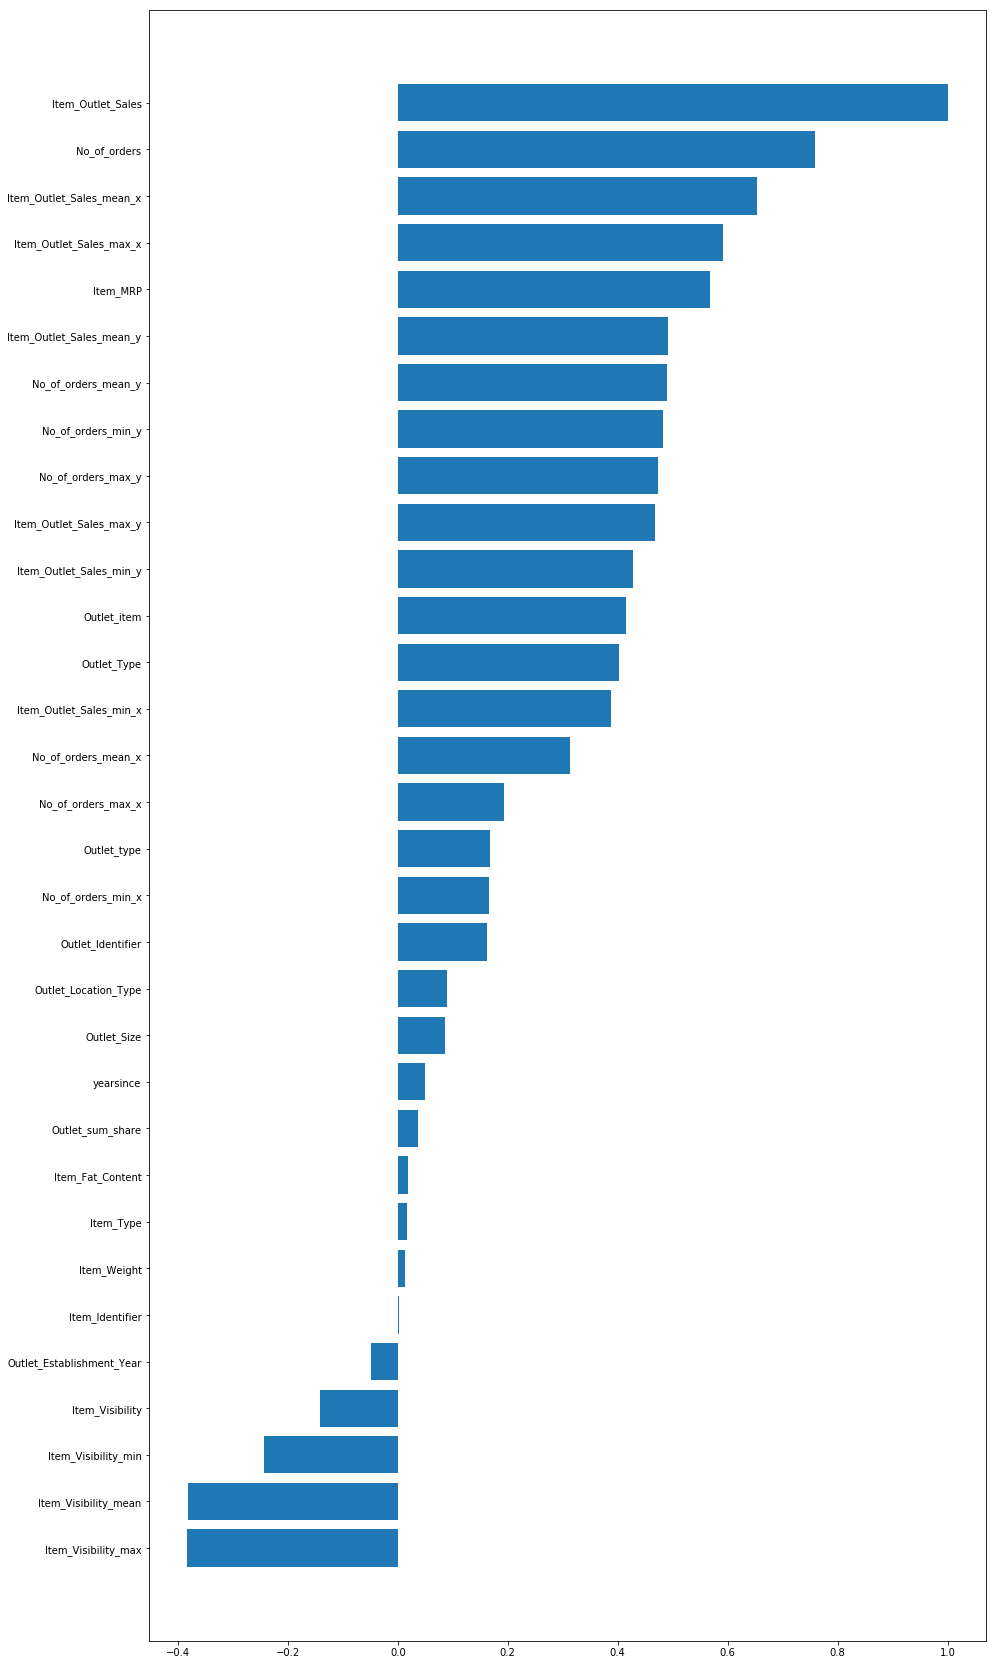

In [393]:
tick = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(15,30))
rects = ax.barh(tick, np.array(corr_df.corr_values.values))
ax.set_yticks(tick)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
plt.show()

In [394]:
imp=corr_df[(corr_df['corr_values']>0.4) | (corr_df['corr_values'] < -0.2)]
imp_var=imp['col_labels'].tolist()

In [395]:
sd=train[imp_var].corr().sort_values(by='Item_Visibility_max')
sd=sd.sort_values(by ='Item_Visibility_max',  axis=1)

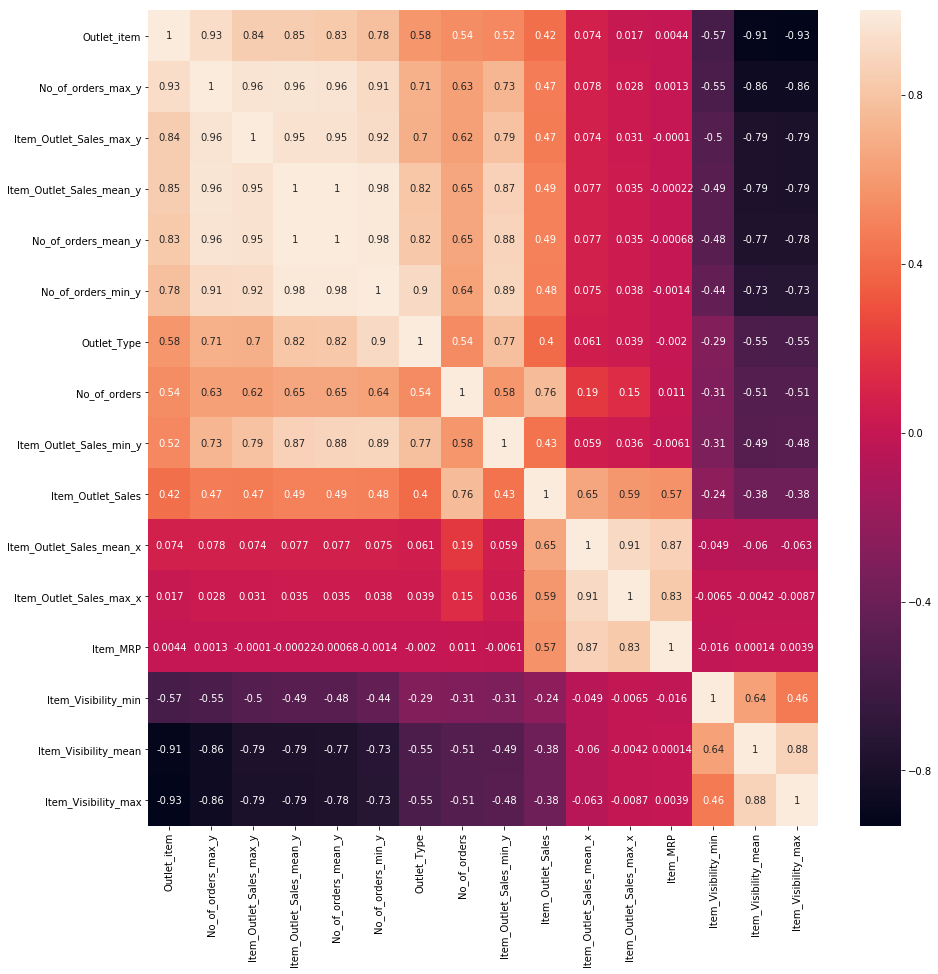

In [396]:
plt.subplots(figsize=(15,15))
sns.heatmap(sd,annot=True)

In [422]:
train.shape

(8523, 30)

In [397]:
train=train.drop(['Outlet_Establishment_Year','No_of_orders'],1)
#test=test.drop(['Outlet_Establishment_Year','No_of_orders'],1)

In [398]:
X=train.drop('Item_Outlet_Sales',1)
y=train['Item_Outlet_Sales']

In [399]:
#from sklearn.model_selection import train_test_split
#train_X, val_x, train_y, val_y = train_test_split(X, y, test_size=0.30, random_state=123)

In [400]:
from sklearn import model_selection
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [412]:
param = {'objective' : 'reg:linear',
            'eta' : 0.01,
            'silent' : 1,
            'eval_metric' : "rmse",
            'min_child_weight' : 3,
            'nthread' : 16,
            'subsample' : 0.8,
            'colsample_bytree' : 0.8,
            'seed' : 1}
para = list(param.items())

In [413]:
import gc
feature=X.columns.tolist()
gc.collect()

80

In [414]:
cv_scores = []
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=123)
for train_index, test_index in kf.split(range(X.shape[0])):
    train_x, test_x = X.loc[train_index,:], X.loc[test_index,:]
    train_y, test_y = y[train_index], y[test_index]
    

    xgtrain = xgb.DMatrix(train_x, train_y, feature_names=feature)
    xgtest = xgb.DMatrix(test_x, test_y, feature_names=feature)
    #xgtest = xgb.DMatrix(test1, feature_names=feature)
    
    watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
    model = xgb.train(para, xgtrain, num_boost_round=3000, evals= watchlist, early_stopping_rounds=20, verbose_eval = 10)   
    
    preds = model.predict(xgtest)
    
    cv_scores.append(mean_absolute_error(test_y, preds))
    break

[0]	train-rmse:2714.37	valid-rmse:2804.5
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:2490.9	valid-rmse:2576.81
[20]	train-rmse:2291.88	valid-rmse:2373.74
[30]	train-rmse:2111.28	valid-rmse:2188.92
[40]	train-rmse:1950.22	valid-rmse:2025.12
[50]	train-rmse:1807.06	valid-rmse:1880.23
[60]	train-rmse:1680.54	valid-rmse:1752.09
[70]	train-rmse:1568.63	valid-rmse:1639.74
[80]	train-rmse:1470.21	valid-rmse:1541.22
[90]	train-rmse:1383.84	valid-rmse:1454.88
[100]	train-rmse:1307.82	valid-rmse:1379.52
[110]	train-rmse:1241.58	valid-rmse:1314.75
[120]	train-rmse:1184.11	valid-rmse:1259.37
[130]	train-rmse:1133.71	valid-rmse:1211.78
[140]	train-rmse:1089.95	valid-rmse:1170.45
[150]	train-rmse:1052.33	valid-rmse:1135.77
[160]	train-rmse:1019.9	valid-rmse:1106.46
[170]	train-rmse:991.176	valid-rmse:1081.53
[180]	train-rmse:966.177	valid-rmse:1060.99
[190]	train-rmse:944.511	valid-rm

In [404]:
#[37]	train-rmse:782.121	valid-rmse:981.7
#train-rmse:818.899	valid-rmse:977.889
#[369]	train-rmse:789.909	valid-rmse:967.729

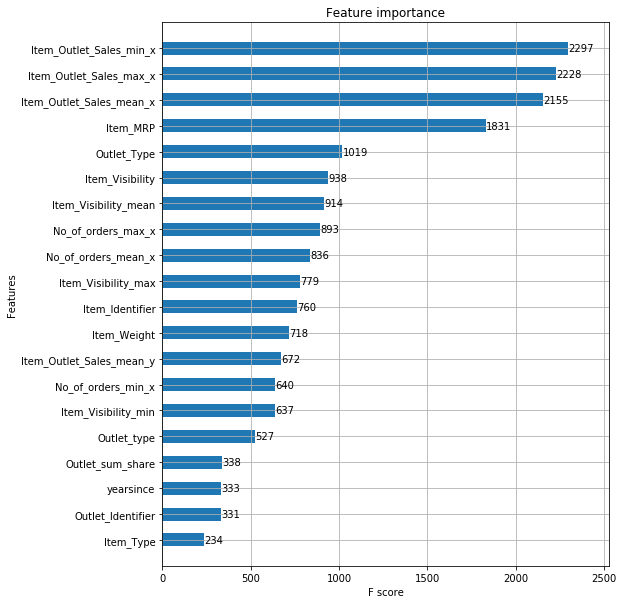

In [415]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

In [416]:
test = test.drop(['Item_Outlet_Sales','Outlet_Establishment_Year'],1)

KeyError: "['Item_Outlet_Sales' 'Outlet_Establishment_Year'] not found in axis"

In [417]:
xgtest = xgb.DMatrix(test, feature_names=feature)

In [418]:
pred_test = model.predict(xgtest)

In [419]:
sub['Item_Outlet_Sales']=pred_test

In [420]:
sub.to_csv('sub.csv',index=False)

In [421]:
sub.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1575.368896
1,FDW14,OUT017,1409.219727
2,NCN55,OUT010,1294.653076
3,FDQ58,OUT017,1954.419556
4,FDY38,OUT027,5360.893066
